In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.compose import ColumnTransformer
import tensorflow.keras.utils as ku
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
songs_data = pd.read_csv('spotify_songs.csv')

def extract_year(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce').year
    except:
        return pd.to_numeric(date_str, errors='coerce')

songs_data['track_album_release_date'] = songs_data['track_album_release_date'].apply(extract_year)

songs_data.drop(columns=['track_id','track_name','track_artist','track_album_id','track_album_name',
                         'playlist_id','playlist_name','playlist_id','playlist_subgenre'],inplace=True)

songs_data.columns = ['popularity','year','genre','danceability','energy','key','loudness','mode',
                      'speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration']

songs_data.dropna(inplace=True)

genres = songs_data['genre'].unique()
map_genres = {genre: i for i, genre in enumerate(genres)}
map_genres

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}

In [3]:
songs_data = songs_data.replace({"genre":map_genres})
songs_data.head()

,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
0,66,2019.0,0,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,67,2019.0,0,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,70,2019.0,0,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,60,2019.0,0,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,69,2019.0,0,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [4]:
songs_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 32832
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        30947 non-null  int64  
 1   year              30947 non-null  float64
 2   genre             30947 non-null  int64  
 3   danceability      30947 non-null  float64
 4   energy            30947 non-null  float64
 5   key               30947 non-null  int64  
 6   loudness          30947 non-null  float64
 7   mode              30947 non-null  int64  
 8   speechiness       30947 non-null  float64
 9   acousticness      30947 non-null  float64
 10  instrumentalness  30947 non-null  float64
 11  liveness          30947 non-null  float64
 12  valence           30947 non-null  float64
 13  tempo             30947 non-null  float64
 14  duration          30947 non-null  int64  
dtypes: float64(10), int64(5)
memory usage: 3.8 MB


In [5]:
songs_data.describe()

,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
count,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000
mean,42.749184,2012.200536,2.548712,0.657259,0.698875,5.368566,-6.639335,0.560927,0.108245,0.175944,0.086942,0.189979,0.505031,120.939630,223950.103467
std,24.955557,10.397763,1.765197,0.143924,0.180716,3.614083,2.948903,0.496282,0.101780,0.220037,0.227394,0.153938,0.232743,26.849668,59113.890261
min,0.000000,1957.000000,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,25.000000,2010.000000,1.000000,0.566000,0.582000,2.000000,-8.073000,0.000000,0.041500,0.015200,0.000000,0.093100,0.326000,99.973500,186750.000000
50%,45.000000,2017.000000,3.000000,0.674000,0.721000,6.000000,-6.093000,1.000000,0.063600,0.081000,0.000015,0.127000,0.506000,122.001000,214400.000000
75%,62.000000,2019.000000,4.000000,0.762000,0.840000,9.000000,-4.605500,1.000000,0.134000,0.256000,0.005060,0.247000,0.687000,133.519000,251133.000000
max,100.000000,2020.000000,5.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [6]:
songs_data.shape

(30947, 15)

In [7]:
songs_data.columns

Index(['popularity', 'year', 'genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration'],
      dtype='object')

In [8]:
train, test = train_test_split(songs_data, test_size=0.2, random_state=106)

X_train = train.drop(['genre'],axis=1)
y_train = train[['genre']]

X_test = test.drop(['genre'],axis=1)
y_test = test[['genre']]

In [10]:
X_test.shape

(6190, 14)

In [13]:
X_train.shape

(24757, 14)

In [11]:
y_test.shape

(6190, 1)

In [12]:
y_train.shape

(24757, 1)

In [14]:
categorical_columns = ['year', 'key', 'mode']

X_train_categorical = X_train[categorical_columns]
X_train_numerical = X_train.drop(categorical_columns, axis=1)

X_test_categorical = X_test[categorical_columns]
X_test_numerical = X_test.drop(categorical_columns, axis=1)

scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

X_train_numerical_scaled_df = pd.DataFrame(X_train_numerical_scaled, columns=X_train_numerical.columns, index=X_train_numerical.index)
X_test_numerical_scaled_df = pd.DataFrame(X_test_numerical_scaled, columns=X_test_numerical.columns, index=X_test_numerical.index)

X_train_scaled = pd.concat([X_train_numerical_scaled_df, X_train_categorical], axis=1)
X_test_scaled = pd.concat([X_test_numerical_scaled_df, X_test_categorical], axis=1)


In [15]:
X_train_scaled

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,year,key,mode
6594,1.052017,-0.083873,-0.131336,0.459124,0.912017,-0.753054,-0.380089,0.544032,-1.431710,-0.015171,-0.247268,2019.0,1,0
4314,-0.149181,0.549914,0.706195,0.593587,-0.234360,-0.798913,-0.347323,-0.949903,1.544165,0.106386,0.200555,2019.0,9,0
24138,-0.669701,-0.174414,-2.216845,-1.904177,-0.725804,-0.344738,-0.380089,0.648457,-1.397357,0.258694,1.110722,2001.0,10,0
4575,-1.350380,0.166856,0.417774,1.177282,-0.295056,-0.348384,-0.380089,1.046579,-1.019468,-0.672712,-1.040435,2016.0,1,0
22740,-1.390420,1.413535,-1.412593,-2.843724,0.216947,1.883685,0.527155,-0.675787,1.737404,-1.079100,-0.262215,2017.0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13668,1.612577,1.134948,-1.368221,-1.073626,-0.724825,1.674059,-0.367141,-0.771727,1.011685,-0.136357,0.513711,1983.0,1,1
19721,1.372337,0.891184,0.301296,0.948422,-0.210864,0.056287,-0.380085,0.491819,-0.070451,-1.002891,-0.414054,2020.0,1,1
30800,-0.149181,-0.459966,0.018421,0.354541,-0.782584,0.224900,-0.380089,1.464280,-0.014627,-0.632737,-0.102325,2019.0,7,1
9625,-0.229261,1.079230,-0.802471,-1.077022,0.980545,0.325156,-0.380089,-0.395796,0.784093,0.926868,1.703419,2003.0,1,0


In [16]:
X_test_scaled

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,year,key,mode
32049,-0.429461,-0.014226,0.550891,0.053695,-0.750278,-0.424032,-0.303017,-0.519801,-1.028056,0.181447,1.765572,2018.0,2,0
10925,0.091058,-0.285849,1.133281,2.091363,-0.147231,-0.732092,-0.375597,-0.317477,-0.250808,1.068802,-0.021692,2015.0,9,1
10433,0.771737,0.807607,0.894778,0.737219,-0.559378,-0.632291,-0.379819,-0.474115,-0.104805,-0.742697,-1.216173,2019.0,11,0
2972,1.252217,-0.132625,1.249759,0.932802,-0.714056,-0.791106,-0.379327,-0.265264,0.105610,-0.336643,0.681313,2015.0,7,1
15626,-1.390420,-1.560387,0.489879,-0.038324,-0.496724,-0.787369,-0.379958,-0.661428,0.247319,-0.285960,0.271608,2009.0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21705,-0.909941,0.814572,-0.685993,-1.187716,2.997228,-0.533402,-0.380089,-0.677745,0.088434,0.330235,-0.179102,2019.0,4,1
21512,-1.150180,-0.285849,-2.743769,-1.625402,-0.741467,3.387529,-0.380089,-0.545908,-0.366751,-1.528465,-0.555056,2018.0,6,0
18588,1.011977,-1.992197,-0.974415,-0.565313,-0.697414,0.639596,-0.380089,-0.690145,-1.259943,1.152421,-0.108661,2018.0,1,1
29175,0.531498,0.194715,0.062793,-0.401987,-0.596579,-0.757156,2.495788,0.955207,-0.701698,0.701315,0.118936,2019.0,0,1


In [17]:
# Naive Bayes
start_time = time.time()
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train.squeeze())
y_pred_nb = nb_classifier.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test.squeeze(), y_pred_nb)
end_time = time.time()
print("Running time for Naive Bayes:", end_time - start_time, "seconds")
print("Accuracy of Naive Bayes:", accuracy_nb)


# Decision Tree
start_time = time.time()
dt_classifier = DecisionTreeClassifier(random_state=106)
dt_classifier.fit(X_train_scaled, y_train.squeeze())
y_pred_dt = dt_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test.squeeze(), y_pred_dt)
end_time = time.time()
print("Running time for Decision Tree:", end_time - start_time, "seconds")
print("Accuracy of Decision Tree:", accuracy_dt)

# Random Forest
start_time = time.time()
rf_classifier = RandomForestClassifier(random_state=106)
rf_classifier.fit(X_train_scaled, y_train.squeeze())
y_pred_rf = rf_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test.squeeze(), y_pred_rf)
end_time = time.time()
print("Running time for Random Forest:", end_time - start_time, "seconds")
print("Accuracy of Random Forest:", accuracy_rf)

# Gradient Boosting Machine
start_time = time.time()
gbm_classifier = GradientBoostingClassifier(random_state=106)
gbm_classifier.fit(X_train_scaled, y_train.squeeze())
y_pred_gbm = gbm_classifier.predict(X_test_scaled)
accuracy_gbm = accuracy_score(y_test.squeeze(), y_pred_gbm)
end_time = time.time()
print("Running time for Gradient Boosting Machine:", end_time - start_time, "seconds")
print("Accuracy of Gradient Boosting Machine:", accuracy_gbm)

Running time for Naive Bayes: 0.02191925048828125 seconds
Accuracy of Naive Bayes: 0.4801292407108239
Running time for Decision Tree: 0.4015958309173584 seconds
Accuracy of Decision Tree: 0.46122778675282716
Running time for Random Forest: 8.368137836456299 seconds
Accuracy of Random Forest: 0.5835218093699516
Running time for Gradient Boosting Machine: 53.654319524765015 seconds
Accuracy of Gradient Boosting Machine: 0.5856219709208401


In [18]:
X_full = np.concatenate((X_train_scaled, X_test_scaled))
y_full = np.concatenate((y_train, y_test))
cv_accuracy_nb = cross_val_score(nb_classifier, X_full, y_full.squeeze(), cv=5).mean()
cv_accuracy_dt = cross_val_score(dt_classifier, X_full, y_full.squeeze(), cv=5).mean()
cv_accuracy_rf = cross_val_score(rf_classifier, X_full, y_full.squeeze(), cv=5).mean()
cv_accuracy_gbm = cross_val_score(gbm_classifier, X_full, y_full.squeeze(), cv=5).mean()
print(f"Cross-Validation Accuracy of Naive Bayes: {cv_accuracy_nb}")
print(f"Cross-Validation Accuracy of Decision Tree: {cv_accuracy_dt}")
print(f"Cross-Validation Accuracy of Random Forest: {cv_accuracy_rf}")
print(f"Cross-Validation Accuracy of Gradient Boosting Machine: {cv_accuracy_gbm}")

Cross-Validation Accuracy of Naive Bayes: 0.470158614311545
Cross-Validation Accuracy of Decision Tree: 0.45607014477455043
Cross-Validation Accuracy of Random Forest: 0.5743044084415756
Cross-Validation Accuracy of Gradient Boosting Machine: 0.5742722026754957


In [19]:
one_hot_columns = ['year', 'key']
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), one_hot_columns)], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_scaled)
X_test_scaled = ct.transform(X_test_scaled)

# One-hot encode labels
y_train_series = y_train.squeeze() 
y_test_series = y_test.squeeze()
y_train = ku.to_categorical(y_train_series, num_classes=6)
y_test = ku.to_categorical(y_test_series, num_classes=6)

In [20]:
# Number of features after one-hot encoding
input_shape = X_train_scaled.shape[1]
# Number of output classes
num_classes = y_train.shape[1]

# Define the model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
mlp_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time = time.time()

# Train the model
history = mlp_model.fit(X_train_scaled, y_train,
                    batch_size=32,
                    epochs=40,
                    verbose=1,
                    validation_data=(X_test_scaled, y_test))

end_time = time.time()

# Evaluate the model
score = mlp_model.evaluate(X_test_scaled, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Running time for MLP:", end_time - start_time, "seconds")



Epoch 1/40


774/774 [==============================] - 3s 3ms/step - loss: 1.3769 - accuracy: 0.4667 - val_loss: 1.2260 - val_accuracy: 0.5273
Epoch 2/40
774/774 [==============================] - 2s 3ms/step - loss: 1.2603 - accuracy: 0.5209 - val_loss: 1.1748 - val_accuracy: 0.5578
Epoch 3/40
774/774 [==============================] - 2s 3ms/step - loss: 1.2195 - accuracy: 0.5338 - val_loss: 1.1473 - val_accuracy: 0.5717
Epoch 4/40
774/774 [==============================] - 2s 3ms/step - loss: 1.1887 - accuracy: 0.5470 - val_loss: 1.1288 - val_accuracy: 0.5735
Epoch 5/40
774/774 [==============================] - 3s 4ms/step - loss: 1.1754 - accuracy: 0.5535 - val_loss: 1.1209 - val_accuracy: 0.5769
Epoch 6/40
774/774 [==============================] - 3s 4ms/step - loss: 1.1604 - accuracy: 0.5617 - val_loss: 1.1149 - val_accuracy: 0.5763
Epoch 7/40
774/774 [==============================] - 3s 4ms/step - loss: 1.1465 - accuracy: 0.5652 - val_loss: 1.1105 - val_accuracy: 0.5834
Ep

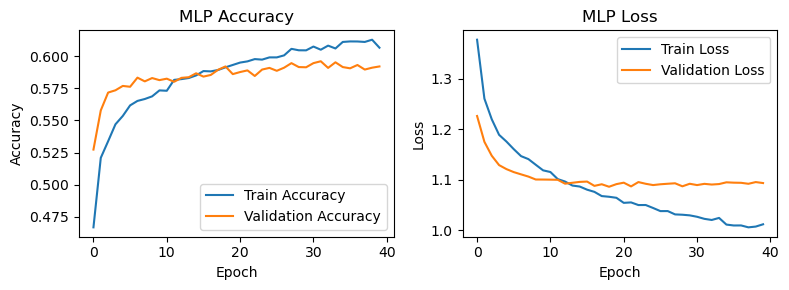

In [21]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MLP Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [22]:
# Define the 1D CNN model
cnn_model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(input_shape, 1)),
    MaxPooling1D(2),
    Conv1D(64, 4, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the 1D CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Reshape data for 1D CNN
X_train_scaled_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Train the 1D CNN model
start_time = time.time()

cnn_history = cnn_model.fit(X_train_scaled_cnn, y_train,
                            batch_size=32,
                            epochs=50,
                            verbose=1,
                            validation_data=(X_test_scaled_cnn, y_test))

end_time = time.time()

# Evaluate the 1D CNN model
cnn_score = cnn_model.evaluate(X_test_scaled_cnn, y_test, verbose=0)
print('1D CNN Test loss:', cnn_score[0])
print('1D CNN Test accuracy:', cnn_score[1])
print("Running time for 1D CNN:", end_time - start_time, "seconds")


Epoch 1/50
774/774 [==============================] - 9s 11ms/step - loss: 1.5465 - accuracy: 0.3566 - val_loss: 1.3576 - val_accuracy: 0.4953
Epoch 2/50
774/774 [==============================] - 8s 10ms/step - loss: 1.4100 - accuracy: 0.4364 - val_loss: 1.2913 - val_accuracy: 0.5113
Epoch 3/50
774/774 [==============================] - 8s 10ms/step - loss: 1.3788 - accuracy: 0.4593 - val_loss: 1.2609 - val_accuracy: 0.5195
Epoch 4/50
774/774 [==============================] - 8s 10ms/step - loss: 1.3512 - accuracy: 0.4739 - val_loss: 1.2695 - val_accuracy: 0.5288
Epoch 5/50
774/774 [==============================] - 8s 11ms/step - loss: 1.3364 - accuracy: 0.4810 - val_loss: 1.2503 - val_accuracy: 0.5328
Epoch 6/50
774/774 [==============================] - 8s 10ms/step - loss: 1.3260 - accuracy: 0.4869 - val_loss: 1.2382 - val_accuracy: 0.5372
Epoch 7/50
774/774 [==============================] - 7s 9ms/step - loss: 1.3182 - accuracy: 0.4892 - val_loss: 1.2164 - val_accuracy: 0.5460

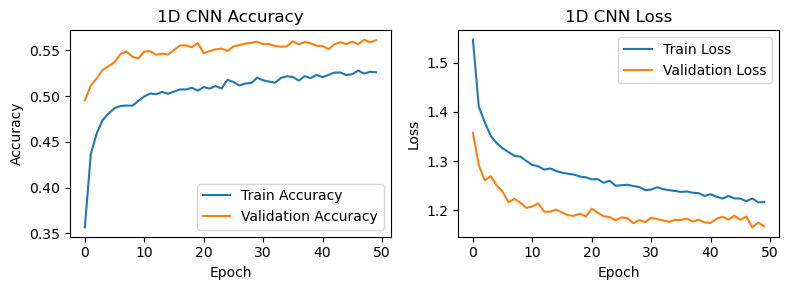

In [23]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('1D CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('1D CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [24]:
# Weighted average of predictions
weight_mlp = 0.7
weight_cnn = 0.3

stacked_X_train = weight_mlp * mlp_model.predict(X_train_scaled) + weight_cnn * cnn_model.predict(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
stacked_X_test = weight_mlp * mlp_model.predict(X_test_scaled) + weight_cnn * cnn_model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define the stacked model
stacked_model = Sequential([
    Dense(64, activation='relu', input_shape=(stacked_X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the stacked model
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the stacked model
start_time = time.time()

stacked_history = stacked_model.fit(stacked_X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(stacked_X_test, y_test))

end_time = time.time()

# Evaluate the stacked model
stacked_score = stacked_model.evaluate(stacked_X_test, y_test, verbose=0)
print('Stacked Model Test loss:', stacked_score[0])
print('Stacked Model Test accuracy:', stacked_score[1])
print("Running time for Stacked Model:", end_time - start_time, "seconds")

194/194 [==============================] - 1s 3ms/step
Epoch 1/50
774/774 [==============================] - 3s 2ms/step - loss: 1.1607 - accuracy: 0.5920 - val_loss: 1.1176 - val_accuracy: 0.5979
Epoch 2/50
774/774 [==============================] - 2s 3ms/step - loss: 1.0127 - accuracy: 0.6466 - val_loss: 1.1219 - val_accuracy: 0.5968
Epoch 3/50
774/774 [==============================] - 2s 3ms/step - loss: 0.9956 - accuracy: 0.6503 - val_loss: 1.1259 - val_accuracy: 0.5985
Epoch 4/50
774/774 [==============================] - 2s 3ms/step - loss: 0.9857 - accuracy: 0.6508 - val_loss: 1.1267 - val_accuracy: 0.5945
Epoch 5/50
774/774 [==============================] - 2s 3ms/step - loss: 0.9793 - accuracy: 0.6529 - val_loss: 1.1236 - val_accuracy: 0.5969
Epoch 6/50
774/774 [==============================] - 2s 3ms/step - loss: 0.9745 - accuracy: 0.6540 - val_loss: 1.1220 - val_accuracy: 0.5948
Epoch 7/50
774/774 [==============================] - 2s 2ms/step - loss: 0.9673 - accuracy: 

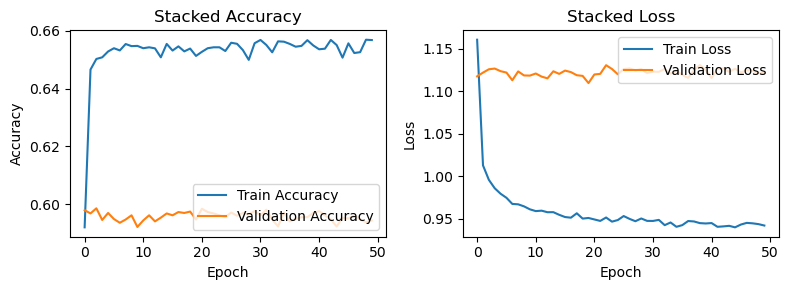

In [25]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(stacked_history.history['accuracy'], label='Train Accuracy')
plt.plot(stacked_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Stacked Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(stacked_history.history['loss'], label='Train Loss')
plt.plot(stacked_history.history['val_loss'], label='Validation Loss')
plt.title('Stacked Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
X_full = np.concatenate((X_train_scaled, X_test_scaled))
y_full = np.concatenate((y_train, y_test))

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=106)

cv_scores = []

for train_index, test_index in kf.split(X_full):
    X_train_kf, X_test_kf = X_full[train_index], X_full[test_index]
    y_train_kf, y_test_kf = y_full[train_index], y_full[test_index]

    mlp_model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    mlp_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    history = mlp_model.fit(X_train_kf, y_train_kf,
                            batch_size=32,
                            epochs=40,
                            verbose=0,
                            validation_data=(X_test_kf, y_test_kf))

    score = mlp_model.evaluate(X_test_kf, y_test_kf, verbose=0)
    cv_scores.append(score[1])  

for i, score in enumerate(cv_scores):
    print(f'Fold {i+1} Accuracy: {score}')

print(f'Mean CV Accuracy: {np.mean(cv_scores)}')

Fold 1 Accuracy: 0.5772213339805603
Fold 2 Accuracy: 0.5815832018852234
Fold 3 Accuracy: 0.5807077288627625
Fold 4 Accuracy: 0.5748909115791321
Fold 5 Accuracy: 0.5748909115791321
Mean CV Accuracy: 0.577858817577362


In [27]:
X_full_cnn = X_full.reshape(X_full.shape[0], X_full.shape[1], 1)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=106)

cv_scores = []

for train_index, test_index in kf.split(X_full_cnn):
    X_train_kf, X_test_kf = X_full_cnn[train_index], X_full_cnn[test_index]
    y_train_kf, y_test_kf = y_full[train_index], y_full[test_index]

    cnn_model = Sequential([
        Conv1D(32, 2, activation='relu', input_shape=(input_shape, 1)),
        MaxPooling1D(2),
        Conv1D(64, 4, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])


    cnn_history = cnn_model.fit(X_train_kf, y_train_kf,
                                batch_size=32,
                                epochs=50,
                                verbose=0,
                                validation_data=(X_test_kf, y_test_kf))

    cnn_score = cnn_model.evaluate(X_test_kf, y_test_kf, verbose=0)
    cv_scores.append(cnn_score[1]) 

for i, score in enumerate(cv_scores):
    print(f'Fold {i+1} Accuracy: {score:.4f}')

print(f'Mean CV Accuracy: {np.mean(cv_scores):.4f}')

Fold 1 Accuracy: 0.5480
Fold 2 Accuracy: 0.5485
Fold 3 Accuracy: 0.5452
Fold 4 Accuracy: 0.5542
Fold 5 Accuracy: 0.5490
Mean CV Accuracy: 0.5490


In [28]:
weight_mlp = 0.7
weight_cnn = 0.3

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=106)

cv_scores = []

for train_index, test_index in kf.split(X_full):
    X_train_kf, X_test_kf = X_full[train_index], X_full[test_index]
    y_train_kf, y_test_kf = y_full[train_index], y_full[test_index]

    X_train_kf_cnn = X_train_kf.reshape(X_train_kf.shape[0], X_train_kf.shape[1], 1)
    X_test_kf_cnn = X_test_kf.reshape(X_test_kf.shape[0], X_test_kf.shape[1], 1)

    stacked_X_train_kf = weight_mlp * mlp_model.predict(X_train_kf) + weight_cnn * cnn_model.predict(X_train_kf_cnn)
    stacked_X_test_kf = weight_mlp * mlp_model.predict(X_test_kf) + weight_cnn * cnn_model.predict(X_test_kf_cnn)

    stacked_model = Sequential([
        Dense(64, activation='relu', input_shape=(stacked_X_train_kf.shape[1],)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    stacked_history = stacked_model.fit(stacked_X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0, validation_data=(stacked_X_test_kf, y_test_kf))

    stacked_score = stacked_model.evaluate(stacked_X_test_kf, y_test_kf, verbose=0)
    cv_scores.append(stacked_score[1]) 

for i, score in enumerate(cv_scores):
    print(f'Fold {i+1} Accuracy: {score:.4f}')

print(f'Mean CV Accuracy: {np.mean(cv_scores):.4f}')

194/194 [==============================] - 0s 2ms/step
Fold 1 Accuracy: 0.6745
Fold 2 Accuracy: 0.6730
Fold 3 Accuracy: 0.6675
Fold 4 Accuracy: 0.6733
Fold 5 Accuracy: 0.5794
Mean CV Accuracy: 0.6535
